(np.float64(-0.5), np.float64(639.5), np.float64(359.5), np.float64(-0.5))

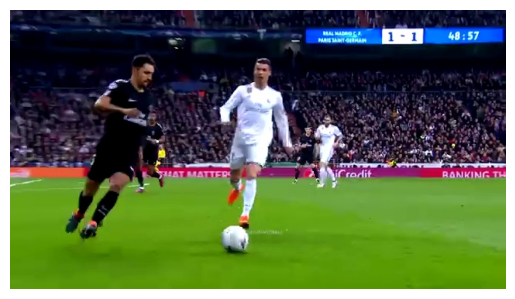

In [26]:
# download yt video
from pytubefix import YouTube

YouTube('https://youtu.be/l3NJNFmg09k').streams.first().download()
yt = YouTube('https://youtu.be/l3NJNFmg09k')


# extract frame 129 from video
import cv2

cap = cv2.VideoCapture("Football match.mp4")
cap.set(cv2.CAP_PROP_POS_FRAMES, 129)
ret, frame = cap.read()
cap.release()
cv2.imwrite("frame_129.jpg", frame)


# show frame 129
import matplotlib.pyplot as plt

img = cv2.imread("frame_129.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.axis("off")

In [19]:
# Use yolo to save results
from ultralytics import YOLO

model = YOLO("yolo11s.pt")
results = model("frame_129.jpg", save=True)


image 1/1 /workspaces/eng-ai-agents/assignments/assignment-3/frame_129.jpg: 384x640 5 persons, 1 sports ball, 479.1ms
Speed: 2.7ms preprocess, 479.1ms inference, 2.6ms postprocess per image at shape (1, 3, 384, 640)
Results saved to /workspaces/eng-ai-agents/runs/detect/predict5


[W1102 05:05:25.671721221 NNPACK.cpp:57] Could not initialize NNPACK! Reason: Unsupported hardware.
[W1102 05:05:25.673857263 NNPACK.cpp:57] Could not initialize NNPACK! Reason: Unsupported hardware.


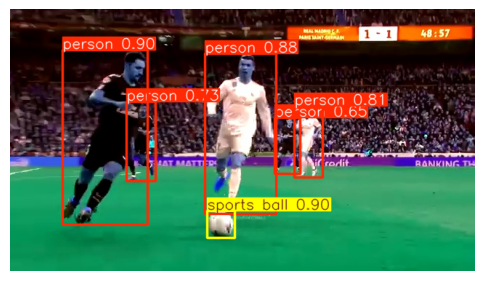

In [27]:
# display result
plt.figure(figsize=(6,6))
plt.imshow(results[0].plot())
plt.axis("off")
plt.show()

YOLO (You Only Look Once) is a single-stage object detection framework that identifies objects and localizes them with bounding boxes in a single forward pass, enabling real-time performance. Its architecture consists of three primary components: a backbone that extracts hierarchical visual features, a neck that integrates multi-scale feature representations to improve detection of objects of varying sizes, and a head that predicts bounding-box coordinates, objectness scores, and class probabilities. Following inference, Non-Max Suppression (NMS) is applied to eliminate redundant detections by retaining only the highest-confidence bounding boxes. This pipeline provides an efficient and effective method for detecting entities such as players and the ball within individual frames.

In [28]:
# hook to capture intermediate feature maps
model = YOLO("yolo11s.pt")
target_layer = model.model.model[3]

feature_maps = []
def hook_fn(module, input, output):
    feature_maps.append(output)

hook_handle = target_layer.register_forward_hook(hook_fn)
_ = model("frame_129.jpg")


image 1/1 /workspaces/eng-ai-agents/assignments/assignment-3/frame_129.jpg: 384x640 5 persons, 1 sports ball, 669.0ms
Speed: 12.4ms preprocess, 669.0ms inference, 11.9ms postprocess per image at shape (1, 3, 384, 640)


[W1103 03:26:19.647556369 NNPACK.cpp:57] Could not initialize NNPACK! Reason: Unsupported hardware.
[W1103 03:26:19.650610952 NNPACK.cpp:57] Could not initialize NNPACK! Reason: Unsupported hardware.


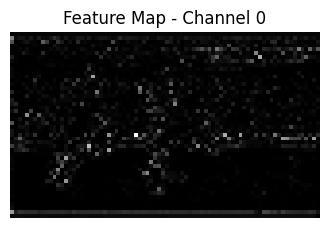

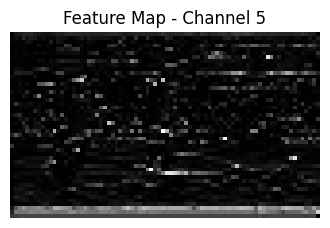

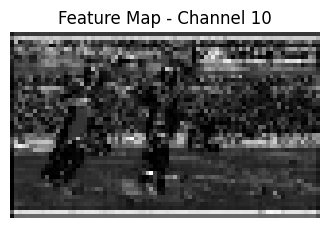

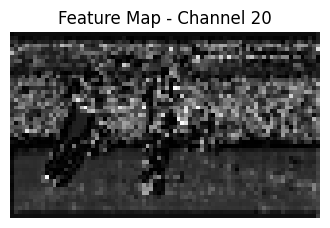

In [29]:
# display feature map channels
fm = feature_maps[0][0]
channels_to_show = [0, 5, 10, 20]

for ch in channels_to_show:
    fmap = fm[ch].detach().cpu().numpy()
    plt.figure(figsize=(4,4))
    plt.imshow(fmap, cmap="gray")
    plt.title(f"Feature Map - Channel {ch}")
    plt.axis("off")
    plt.show()

hook_handle.remove()

These feature maps provide insight into the intermediate representations learned by YOLO during inference. Early layers focus on low-level visual patterns such as edges, colors, and simple textures, while deeper layers capture higher-level semantic structure, including shapes and object-specific cues (e.g., players or the ball). To inspect these internal activations, I attach a forward hook to a chosen intermediate layer, and a subset of channels is visualized to highlight how the model progressively transforms raw pixels into meaningful features used for detection.

Non-Maximum Suppression (NMS) is a post-processing method that refines YOLO’s raw predictions by eliminating overlapping bounding boxes that refer to the same object. Since the model may output several candidate boxes with different confidence scores, NMS prioritizes the most confident prediction and discards others that have a high Intersection-over-Union (IoU) with it. This is done by ranking detections by confidence, keeping the top one, and suppressing any boxes that overlap beyond a chosen IoU threshold. As a result, NMS ensures that each real object in the scene, such as a player or the ball, is represented by a single, highest-quality bounding box. Even though YOLO handles NMS automatically, it remains a key concept because it explains how the detector converts many raw proposals into a clean and interpretable final output.